## Interpretation of TF models trained on UniRef90 dataset for multiclass classification

In [2]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python310.zip',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/lib-dynload',
 '',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/..']

In [37]:
from prediction.models.nlp import transformer
from src.utils import utils, nn_utils

import torch
import torch.nn.functional as F

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


### Load the trained model

In [4]:
model_path = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/uniref90/20230501/host_multi/transformer-crossentropy_itr4.pth"


label_groupings = {"Human": [ "Homo sapiens" ],
                  "Desert warthog": [ "Phacochoerus aethiopicus" ],
                  "Lesser bandicoot rat": [ "Bandicota bengalensis" ],
                  "Horse": [ "Equus caballus" ],
                  "Goat": [ "Capra hircus" ],
                  "Red junglefowl": [ "Gallus gallus" ],
                  "Wood mouse": [ "Apodemus sylvaticus" ],
                  "Cattle": [ "Bos taurus" ],
                  "Others": [ "*" ]}
host_classes = ["Homo sapiens",  "Phacochoerus aethiopicus",    "Bandicota bengalensis",     "Equus caballus",   "Capra hircus", 
                "Gallus gallus",   "Apodemus sylvaticus",     "Bos taurus",  "Others"]

amino_acid_idx_map = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5,
                  'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
                  'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15,
                  'O': 16, 'S': 17, 'U': 18, 'T': 19, 'W': 20,
                  'Y': 21, 'V': 22, 'B': 23, 'Z': 24, 'X': 25,
                  'J': 26}
idx_amino_acid_map = {v:k for k,v in amino_acid_idx_map.items()}

train_sequence_settings =  {
    "sequence_col": "seq",
    "batch_size": 8,
    "max_sequence_length": 1024,
    "pad_sequence_val": 0,
    "truncate": True
}

test_sequence_settings =  train_sequence_settings.copy()
test_sequence_settings["batch_size"] = 1

label_settings = {
    "label_col": "virus_host_name",
    "exclude_labels": [ "nan"],
    "label_groupings":  label_groupings
}

model = {
    "max_seq_len": 1024,
    "loss": "CrossEntropyLoss",
    "with_convolution": False,
    "n_heads": 8,
    "depth": 6,
    "n_tokens": 27,
    "n_classes": 9,
    "n_epochs": 10,
    "dim": 512
}

In [5]:
nlp_model = transformer.get_transformer_model(model)
# nlp_model = ClassificationTransformer(n_tokens=27, seq_len=sequence_settings["sequence_max_length"], n_classes=len(host_classes), N=6, d=512, d_ff=2048, h=8)
nlp_model.load_state_dict(torch.load(model_path))
nlp_model = nlp_model.to(nn_utils.get_device())

Transformer(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(27, 512)
    (positional_embedding): Embedding(1024, 512)
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=512, out_features=512, bias=True)
          (W_K): Linear(in_features=512, out_features=512, bias=True)
          (W_V): Linear(in_features=512, out_features=512, bias=True)
          (W_O): Linear(in_features=512, out_features=512, bias=True)
        )
        (feed_forward): FeedForwardLayer(
          (W_1): Linear(in_features=512, out_features=2048, bias=True)
          (W_2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (residual_connections): ModuleList(
          (0-1): 2 x ResidualConnectionLayer(
            (norm): NormalizationLayer()
          )
        )
      )
    )
    (norm): NormalizationLayer()
  )
  (linear): Linear(in_features=512, out_features=9, b

### Load the datasets

In [6]:
def load_dataset(input_dir, input_file_names, sequence_settings):
    df = utils.read_dataset(input_dir, input_file_names, cols=[sequence_settings["sequence_col"], label_settings["label_col"]])
    df, index_label_map = utils.transform_labels(df, label_settings, classification_type="multi")
    dataset_loader = nn_utils.get_dataset_loader(df, sequence_settings, label_settings["label_col"])
    return index_label_map, dataset_loader

In [7]:
input_dir = "/home/grads/blessyantony/dev/git/zoonosis/input/data/uniref90/splits/s79221635"
train_file_names = ["uniref90_final.csv_tr0.8_train.csv"]
test_file_names = ["uniref90_final.csv_tr0.8_test.csv"]

In [8]:
index_label_map, train_dataset_loader = load_dataset(input_dir, train_file_names, train_sequence_settings)
for _, record in enumerate(train_dataset_loader):
    sequence, label = record
    print(sequence.shape)
    print(sequence)
    print(label.shape)
    print(label)
    break

input file: /home/grads/blessyantony/dev/git/zoonosis/input/data/uniref90/splits/s79221635/uniref90_final.csv_tr0.8_train.csv, size = (15274, 2)
Size of input dataset = (15274, 2)
Grouping labels using config : {'Human': ['Homo sapiens'], 'Desert warthog': ['Phacochoerus aethiopicus'], 'Lesser bandicoot rat': ['Bandicota bengalensis'], 'Horse': ['Equus caballus'], 'Goat': ['Capra hircus'], 'Red junglefowl': ['Gallus gallus'], 'Wood mouse': ['Apodemus sylvaticus'], 'Cattle': ['Bos taurus'], 'Others': ['*']}
label_idx_map={'Cattle': 0, 'Desert warthog': 1, 'Goat': 2, 'Horse': 3, 'Human': 4, 'Lesser bandicoot rat': 5, 'Others': 6, 'Red junglefowl': 7, 'Wood mouse': 8}
idx_label_map={0: 'Cattle', 1: 'Desert warthog', 2: 'Goat', 3: 'Horse', 4: 'Human', 5: 'Lesser bandicoot rat', 6: 'Others', 7: 'Red junglefowl', 8: 'Wood mouse'}
[4 3 0 6 5 1 2 8 7]
torch.Size([8, 1024])
tensor([[ 6,  9,  8,  ...,  0,  0,  0],
        [13,  7,  3,  ...,  0,  0,  0],
        [13,  6, 11,  ...,  0,  0,  0],
  

In [9]:
index_label_map, test_dataset_loader = load_dataset(input_dir, test_file_names, test_sequence_settings)
for _, record in enumerate(test_dataset_loader):
    sequence, label = record
    print(sequence.shape)
    print(sequence)
    print(label.shape)
    print(label)
    break

input file: /home/grads/blessyantony/dev/git/zoonosis/input/data/uniref90/splits/s79221635/uniref90_final.csv_tr0.8_test.csv, size = (3819, 2)
Size of input dataset = (3819, 2)
Grouping labels using config : {'Human': ['Homo sapiens'], 'Desert warthog': ['Phacochoerus aethiopicus'], 'Lesser bandicoot rat': ['Bandicota bengalensis'], 'Horse': ['Equus caballus'], 'Goat': ['Capra hircus'], 'Red junglefowl': ['Gallus gallus'], 'Wood mouse': ['Apodemus sylvaticus'], 'Cattle': ['Bos taurus'], 'Others': ['*']}
label_idx_map={'Cattle': 0, 'Desert warthog': 1, 'Goat': 2, 'Horse': 3, 'Human': 4, 'Lesser bandicoot rat': 5, 'Others': 6, 'Red junglefowl': 7, 'Wood mouse': 8}
idx_label_map={0: 'Cattle', 1: 'Desert warthog', 2: 'Goat', 3: 'Horse', 4: 'Human', 5: 'Lesser bandicoot rat', 6: 'Others', 7: 'Red junglefowl', 8: 'Wood mouse'}
[4 5 3 1 7 8 6 0 2]
torch.Size([1, 1024])
tensor([[ 7,  4, 20,  ...,  0,  0,  0]], device='cuda:0')
torch.Size([1])
tensor([4], device='cuda:0')


### Training-based interpretation
#### Encoding visualization - all viruses, all hosts

In [10]:
def compute_training_set_representations():
    nlp_model.eval()
    seq_dfs = []
    for _, record in enumerate(train_dataset_loader):
        seq, label = record
        output = nlp_model(seq)
        seq_encoding = nlp_model.encoder.encoding
        # embedding = value for each dimension = mean of the dimensional values of all tokens in the input sequence
        seq_encoding = torch.mean(seq_encoding, dim=1, keepdim=True)
        seq_df = pd.DataFrame(seq_encoding.squeeze().cpu().detach().numpy())
        seq_df["label"] = label.squeeze().cpu().detach().numpy()
        seq_dfs.append(seq_df)
    df = pd.concat(seq_dfs)
    print(df.shape)
    return df

In [11]:
train_rep_df = compute_training_set_representations()

(15274, 513)


In [12]:
from sklearn.manifold import TSNE

def visualize_training_dataset():
    columns = train_rep_df.columns
    print(columns)
    X = train_rep_df[range(512)]
    tsne_model = TSNE(n_components=2, verbose=1, init="pca", learning_rate="auto").fit(X)
    X_emb = pd.DataFrame(tsne_model.fit_transform(X))
    print(X_emb.shape)
    print(X_emb)
    X_emb["label"] = train_rep_df["label"].values
    return tsne_model, X_emb
    

In [13]:
tsne_model, X_emb = visualize_training_dataset()

Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,
       ...
           503,     504,     505,     506,     507,     508,     509,     510,
           511, 'label'],
      dtype='object', length=513)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15274 samples in 0.010s...
[t-SNE] Computed neighbors for 15274 samples in 6.521s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15274
[t-SNE] Computed conditional probabilities for sample 2000 / 15274
[t-SNE] Computed conditional probabilities for sample 3000 / 15274
[t-SNE] Computed conditional probabilities for sample 4000 / 15274
[t-SNE] Computed conditional probabilities for sample 5000 / 15274
[t-SNE] Computed conditional probabilities for sample 6000 / 15274
[t-SNE] Computed conditional probabilities for sample 7000 / 15274
[t-SNE] Computed conditional probabilities for sample 8000 / 15274
[t-SNE] Computed conditional probabilities for sample 9000 / 15274


/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.919136
[t-SNE] KL divergence after 1000 iterations: 1.062824
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15274 samples in 0.008s...
[t-SNE] Computed neighbors for 15274 samples in 6.896s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15274
[t-SNE] Computed conditional probabilities for sample 2000 / 15274
[t-SNE] Computed conditional probabilities for sample 3000 / 15274
[t-SNE] Computed conditional probabilities for sample 4000 / 15274
[t-SNE] Computed conditional probabilities for sample 5000 / 15274
[t-SNE] Computed conditional probabilities for sample 6000 / 15274
[t-SNE] Computed conditional probabilities for sample 7000 / 15274
[t-SNE] Computed conditional probabilities for sample 8000 / 15274
[t-SNE] Computed conditional probabilities for sample 9000 / 15274
[t-SNE] Computed conditional probabilities for sample 10000 / 15274
[t-SNE] Computed conditional probabilities for sample 

/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.922729
[t-SNE] KL divergence after 1000 iterations: 1.062573
(15274, 2)
               0          1
0     -73.734200  65.710815
1      24.014799 -22.032133
2      57.077705 -44.636887
3      39.508930   2.292189
4     -13.232092  45.752594
...          ...        ...
15269  81.353615 -30.292528
15270 -14.313758  20.776472
15271 -51.643818  40.951588
15272 -57.742764  23.853409
15273 -20.733904  28.077467

[15274 rows x 2 columns]


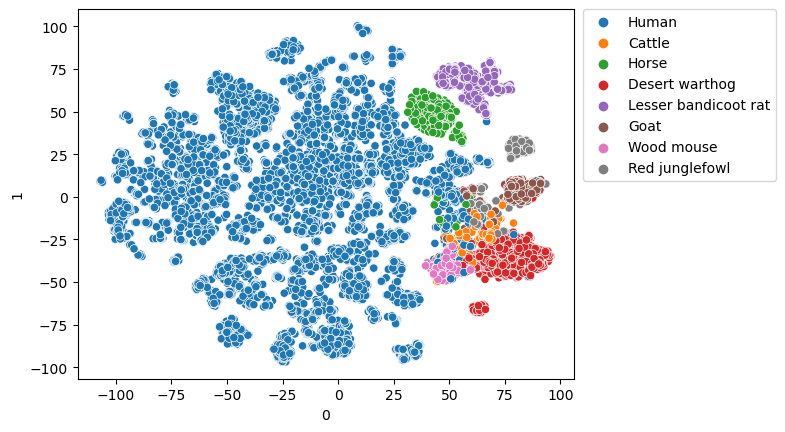

In [14]:
rep_df = X_emb.copy()
rep_df["label"] = rep_df["label"].map(index_label_map)
rep_df = rep_df[rep_df["label"] != "Others"]
ax = sns.scatterplot(data = rep_df, x=0, y=1, hue="label")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

In [15]:
def visualize_prediction(seq, label, train_rep_df):
    nlp_model.eval()
    output = nlp_model(seq)
    seq_encoding = nlp_model.encoder.encoding
    seq_encoding = torch.mean(seq_encoding, dim=1, keepdim=True)

    seq_df = pd.DataFrame(seq_encoding.squeeze(1).cpu().detach().numpy())
    seq_df["label"] = label.squeeze().cpu().detach().numpy()
    sample_pred = torch.argmax(F.softmax(output, dim=1), dim=1)
    print(f"Label {label} = {index_label_map[label.item()]}")
    sample_pred_mapped = index_label_map[sample_pred.item()]
    print(f"Prediction {sample_pred}= {sample_pred_mapped}")
    seq_df["label"] = "prediction-" + sample_pred_mapped
    
    train_rep_df_copy = train_rep_df.copy()
    train_rep_df_copy["label"] = train_rep_df["label"].map(index_label_map)
    train_rep_df_copy = train_rep_df_copy[train_rep_df_copy["label"] != "Others"]
    train_seq_df = pd.concat([train_rep_df_copy, seq_df])
    print(f"train_seq_df shape = {train_seq_df.shape}")
    X = train_seq_df[range(512)]
    print(f"X shape = {X.shape}")
    X_emb = pd.DataFrame(tsne_model.fit_transform(X))
    print(f"X_emb shape = {X_emb.shape}")
    X_emb["label"] = train_seq_df["label"].values
    print(f"X_emb shape = {X_emb.shape}")
    sns.scatterplot(data = X_emb, x=0, y=1, hue="label")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()

Label tensor([4], device='cuda:0') = Human
Prediction tensor([4], device='cuda:0')= Human
train_seq_df shape = (14663, 513)
X shape = (14663, 512)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 14663 samples in 0.028s...
[t-SNE] Computed neighbors for 14663 samples in 6.184s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14663
[t-SNE] Computed conditional probabilities for sample 2000 / 14663
[t-SNE] Computed conditional probabilities for sample 3000 / 14663
[t-SNE] Computed conditional probabilities for sample 4000 / 14663
[t-SNE] Computed conditional probabilities for sample 5000 / 14663
[t-SNE] Computed conditional probabilities for sample 6000 / 14663
[t-SNE] Computed conditional probabilities for sample 7000 / 14663
[t-SNE] Computed conditional probabilities for sample 8000 / 14663
[t-SNE] Computed conditional probabilities for sample 9000 / 14663
[t-SNE] Computed conditional probabilities for sample 10000 / 14663
[t-SNE] Computed conditional probabilit

/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.346954
[t-SNE] KL divergence after 1000 iterations: 1.013119
X_emb shape = (14663, 2)
X_emb shape = (14663, 3)


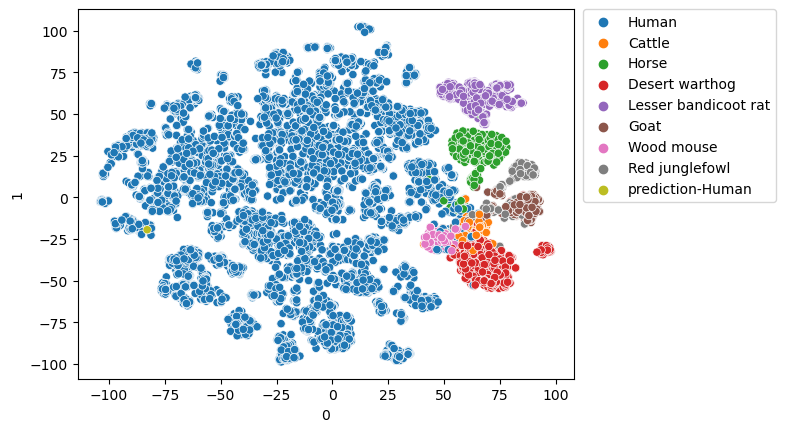

In [16]:
for _, record in enumerate(test_dataset_loader):
    seq, label = record
    visualize_prediction(seq, label, train_rep_df)
    break

#### Coronavirus only

In [17]:
full_dataset_df = pd.read_csv("/home/grads/blessyantony/dev/git/zoonosis/input/data/uniref90/uniref_data/uniref90_final.csv")
full_dataset_df["virus_name"].unique()

array(['Hepatitis B virus', 'Paslahepevirus balayani',
       'Dobrava-Belgrade orthohantavirus', 'West Nile virus',
       'Small ruminant morbillivirus', 'African swine fever virus',
       'Lymphocytic choriomeningitis mammarenavirus', 'Orf virus',
       'Macacine alphaherpesvirus 1', 'Infectious bursal disease virus',
       'Usutu virus', 'Carnivore protoparvovirus 1',
       'Lassa mammarenavirus', 'Vesicular exanthema of swine virus',
       'Tula orthohantavirus', 'Chikungunya virus', 'Vaccinia virus',
       'Kyasanur Forest disease virus', 'Bovine gammaherpesvirus 4',
       'Monkeypox virus', 'Sindbis virus', 'African horse sickness virus',
       'Cowpox virus', 'Getah virus', 'Zika virus',
       'Papiine alphaherpesvirus 2',
       'Epizootic hemorrhagic disease virus', 'Guanarito mammarenavirus',
       'Severe acute respiratory syndrome-related coronavirus',
       'Sheeppox virus', 'Lyssavirus mokola', 'Borna disease virus',
       'Nipah henipavirus', 'Ilheus virus',

In [18]:
coronaviruses = ["Severe acute respiratory syndrome-related coronavirus", "Middle East respiratory syndrome-related coronavirus", "Avian coronavirus", "Thrush coronavirus HKU12-600", "Middle East respiratory syndrome-related coronavirus", "Murine coronavirus", "Betacoronavirus 1"]
uniref90_coronaviruses_df = full_dataset_df[full_dataset_df["virus_name"].isin(coronaviruses)]
print(uniref90_coronaviruses_df.shape)
uniref90_coronaviruses_df.head()

(63, 8)


,uniref90_id,tax_id,host_tax_ids,virus_name,virus_taxon_rank,virus_host_name,virus_host_taxon_rank,seq
3871,UniRef90_A0A1W6S798,694009,9606,Severe acute respiratory syndrome-related coro...,species,Homo sapiens,species,MDLFMSIFTLGSITRQSSKIENASPASTVHTTATIPLQASLPFGWL...
6134,UniRef90_A0A3Q8AD31,694009,9606,Severe acute respiratory syndrome-related coro...,species,Homo sapiens,species,MDNKDRAMRLALRLVSQITLTITRMETVLELGLSIEDRKALLTTRH...
6135,UniRef90_A0A3Q8B233,694009,9606,Severe acute respiratory syndrome-related coro...,species,Homo sapiens,species,MFSLVEFQVTIAELLIIIMRSLGIGLVQFQIRMIALLKIISKHLDR...
6292,UniRef90_A0A3S6GUI8,694009,9606,Severe acute respiratory syndrome-related coro...,species,Homo sapiens,species,MKFLLLLIVVNVALADLYHYQECARGTTVLLSEPCSPNTYEGNSPY...
8013,UniRef90_A0A7G6UAJ9,694009,89399,Severe acute respiratory syndrome-related coro...,species,Rhinolophus sinicus,species,MKILIFAFLANLAKAQEGCGIISRKPQPKMAQVSSSRRGVYYNDDI...


In [19]:
uniref90_coronaviruses_df.to_csv("/home/grads/blessyantony/dev/git/zoonosis/input/data/uniref90/uniref_data/uniref90_coronavirus.csv", index=False)

### Training-based interpretation
#### KNN - SARS CoV-2 virus - Human host only

In [20]:
def analyze_knn(seq, label):
    nlp_model.eval()
    output = nlp_model(seq)
    seq_encoding = nlp_model.encoder.encoding
    seq_encoding = torch.mean(seq_encoding, dim=1, keepdim=True)
    seq_df = pd.DataFrame(seq_encoding.squeeze().cpu().detach().numpy())
    seq_df["label"] = label.squeeze().cpu().detach().numpy()
    print(output)
    sample_pred = torch.argmax(F.softmax(output, dim=1), dim=1)
    print(f"Label {label} = {index_label_map[label.item()]}")
    print(f"Prediction {sample_pred}= {index_label_map[sample_pred.item()]}")

In [21]:
print(index_label_map)

{0: 'Cattle', 1: 'Desert warthog', 2: 'Goat', 3: 'Horse', 4: 'Human', 5: 'Lesser bandicoot rat', 6: 'Others', 7: 'Red junglefowl', 8: 'Wood mouse'}


In [22]:
for _, record in enumerate(test_dataset_loader):
    seq, label = record
    analyze_knn(seq, label)
    break

tensor([[-1.3343, -1.5357, -2.7969, -1.6839, 10.7402, -2.2084,  0.8834, -1.7631,
         -0.9769]], device='cuda:0', grad_fn=<AddmmBackward0>)
Label tensor([4], device='cuda:0') = Human
Prediction tensor([4], device='cuda:0')= Human


### Testing-based interpretation
#### Attention based interpretation

In [23]:
def compute_mean_attn_values():
    attn_values = nlp_model.encoder.layers[5].self_attn.self_attn.squeeze()
    return torch.mean(attn_values, dim=0)


def plot_mean_attention_values(x, seq=None, seq_len=None):
    ticklabels = seq.cpu().detach().numpy().squeeze()[:seq_len]
    ticklabels_mapped = [idx_amino_acid_map[x] for x in ticklabels]

    plt.rcParams['xtick.labelsize'] = 5
    plt.rcParams['ytick.labelsize'] = 5
    plt.figure(figsize=(12,12))
    data = x.cpu().detach().numpy()
    
    sns.heatmap(data=data[:seq_len, :seq_len], xticklabels=ticklabels_mapped, yticklabels=ticklabels_mapped)
    #plt.xticks(rotation=20)
    plt.show()


def plot_mean_of_mean_attention_values(x, seq=None, seq_len=None, seq_max_length=None):
    tokens = seq.cpu().detach().numpy().squeeze()
    
    x = torch.mean(x, dim=0)
    df = pd.DataFrame({"tokens": tokens, "attn_vals": x.cpu().detach().numpy(), "pos": range(seq_max_length)})
    df["tokens"] = df["tokens"].map(idx_amino_acid_map)
    df = df.dropna()
    sorted_df = df.sort_values(by="attn_vals", ascending=False).head(10)
    print("Top 10 tokens + positions with highest attention values for the whole sequence")
    print(sorted_df.head(10))
    plt.rcParams['xtick.labelsize'] = 8
    plt.rcParams['ytick.labelsize'] = 8
    plt.figure(figsize=(12,6))
    sns.scatterplot(data=df, x="pos", y="attn_vals", hue="tokens")
    plt.show()

In [24]:
def analyze_attention_of_prediction(sample_seq, sample_label, seq_max_length):
    # sample_seq = sample_seq.unsqueeze(0)
    seq_len= torch.count_nonzero(sample_seq)
    print(sample_seq.shape)
    print(f"seq_len = {seq_len}")
    
    nlp_model.eval()
    output = nlp_model(sample_seq)
    sample_pred = torch.argmax(F.softmax(nlp_model(sample_seq), dim=1), dim=1)
    print(f"Label = {index_label_map[sample_label.item()]}")
    print(f"Prediction = {index_label_map[sample_pred.item()]}")
    mean_attn_values = compute_mean_attn_values()

    plot_mean_attention_values(mean_attn_values, seq=sample_seq, seq_len=seq_len)
    plot_mean_of_mean_attention_values(mean_attn_values, seq=sample_seq, seq_len=seq_len, seq_max_length=seq_max_length) 

In [58]:
def analyze_attention_of_df(dataset_loader, seq_max_length):
    attn_dfs = []
    max_seq_len_actual = 0
    for _, record in enumerate(dataset_loader):
        seq, label = record
        seq_len = torch.count_nonzero(seq).item()
        print(seq_len)
        if seq_len > max_seq_len_actual:
            max_seq_len_actual = seq_len
        nlp_model(seq)
        mean_attn_values = compute_mean_attn_values()
        mean_of_mean = torch.mean(mean_attn_values, dim=0, keepdim=True)
        attn_dfs.append(mean_of_mean.cpu().detach().numpy())
    print("max_seq_len_actual = ", max_seq_len_actual)
    attn_df = np.concatenate(attn_dfs, axis=0)
    plt.figure(figsize=(12,12))
    sns.heatmap(data=attn_df[:,:max_seq_len_actual])

In [25]:
def load_dataset_with_df(df, sequence_settings):
    df = df[[sequence_settings["sequence_col"], label_settings["label_col"]]]
    df, index_label_map = utils.transform_labels(df, label_settings, classification_type="multi")
    dataset_loader = nn_utils.get_dataset_loader(df, sequence_settings, label_settings["label_col"])
    return index_label_map, dataset_loader

In [61]:
uniref90_coronaviruses_df = pd.read_csv("/home/grads/blessyantony/dev/git/zoonosis/input/data/uniref90/uniref_data/uniref90_coronavirus.csv")
print(uniref90_coronaviruses_df["virus_host_name"].unique())
uniref90_coronaviruses_df.head()

['Homo sapiens' 'Rhinolophus sinicus' 'Meleagris gallopavo'
 'Turdus hortulorum' 'Camelus dromedarius' 'Mus musculus' 'Gallus gallus'
 'Rattus norvegicus' 'Bos taurus' 'Rhinolophus macrotis']


,uniref90_id,tax_id,host_tax_ids,virus_name,virus_taxon_rank,virus_host_name,virus_host_taxon_rank,seq
0,UniRef90_A0A1W6S798,694009,9606,Severe acute respiratory syndrome-related coro...,species,Homo sapiens,species,MDLFMSIFTLGSITRQSSKIENASPASTVHTTATIPLQASLPFGWL...
1,UniRef90_A0A3Q8AD31,694009,9606,Severe acute respiratory syndrome-related coro...,species,Homo sapiens,species,MDNKDRAMRLALRLVSQITLTITRMETVLELGLSIEDRKALLTTRH...
2,UniRef90_A0A3Q8B233,694009,9606,Severe acute respiratory syndrome-related coro...,species,Homo sapiens,species,MFSLVEFQVTIAELLIIIMRSLGIGLVQFQIRMIALLKIISKHLDR...
3,UniRef90_A0A3S6GUI8,694009,9606,Severe acute respiratory syndrome-related coro...,species,Homo sapiens,species,MKFLLLLIVVNVALADLYHYQECARGTTVLLSEPCSPNTYEGNSPY...
4,UniRef90_A0A7G6UAJ9,694009,89399,Severe acute respiratory syndrome-related coro...,species,Rhinolophus sinicus,species,MKILIFAFLANLAKAQEGCGIISRKPQPKMAQVSSSRRGVYYNDDI...


##### Coronavirus: Humans

Grouping labels using config : {'Human': ['Homo sapiens'], 'Desert warthog': ['Phacochoerus aethiopicus'], 'Lesser bandicoot rat': ['Bandicota bengalensis'], 'Horse': ['Equus caballus'], 'Goat': ['Capra hircus'], 'Red junglefowl': ['Gallus gallus'], 'Wood mouse': ['Apodemus sylvaticus'], 'Cattle': ['Bos taurus'], 'Others': ['*']}
label_idx_map={'Cattle': 0, 'Desert warthog': 1, 'Goat': 2, 'Horse': 3, 'Human': 4, 'Lesser bandicoot rat': 5, 'Others': 6, 'Red junglefowl': 7, 'Wood mouse': 8}
idx_label_map={0: 'Cattle', 1: 'Desert warthog', 2: 'Goat', 3: 'Horse', 4: 'Human', 5: 'Lesser bandicoot rat', 6: 'Others', 7: 'Red junglefowl', 8: 'Wood mouse'}
[4]
torch.Size([1, 1024])
seq_len = 43
Label = Human
Prediction = Human


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/../../src/utils/utils.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/../../src/utils/utils.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/../../src/utils/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

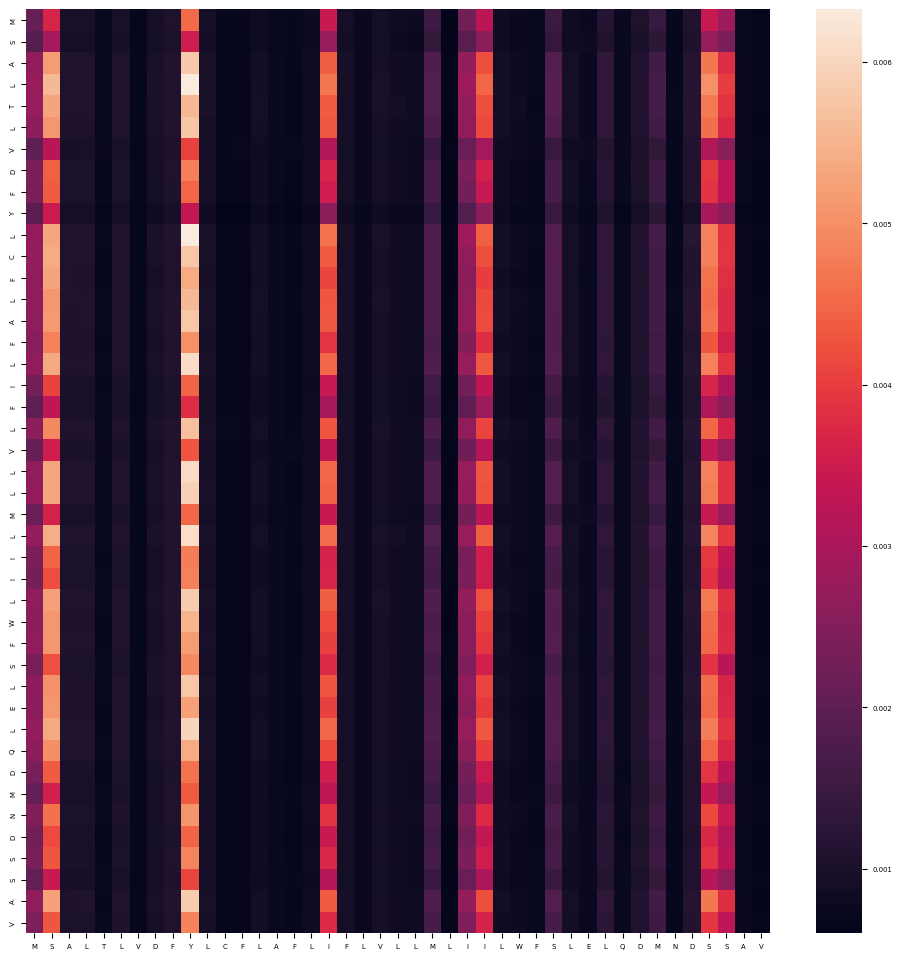

Top 10 tokens + positions with highest attention values for the whole sequence
   tokens  attn_vals  pos
9       Y   0.003193    9
1       S   0.002946    1
39      S   0.002749   39
17      I   0.002565   17
26      I   0.002492   26
40      S   0.002394   40
0       M   0.001892    0
25      I   0.001842   25
30      S   0.001393   30
23      M   0.001378   23


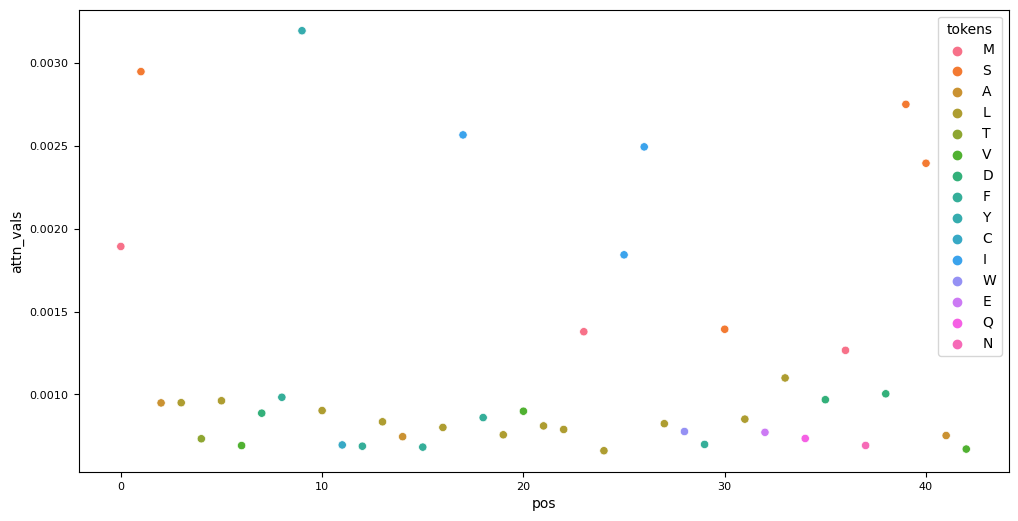

In [27]:
_, test_dataset_loader = load_dataset_with_df(uniref90_coronaviruses_df[uniref90_coronaviruses_df["virus_host_name"] == "Homo sapiens"], test_sequence_settings)
for _, record in enumerate(test_dataset_loader):
    seq, label = record
    analyze_attention_of_prediction(seq, label, test_sequence_settings["max_sequence_length"])
    break

20
1024
274
38
230
73
39
527
122
119
276
98
237
61
63
96
84
154
125
43
70
max_seq_len_actual =  1024


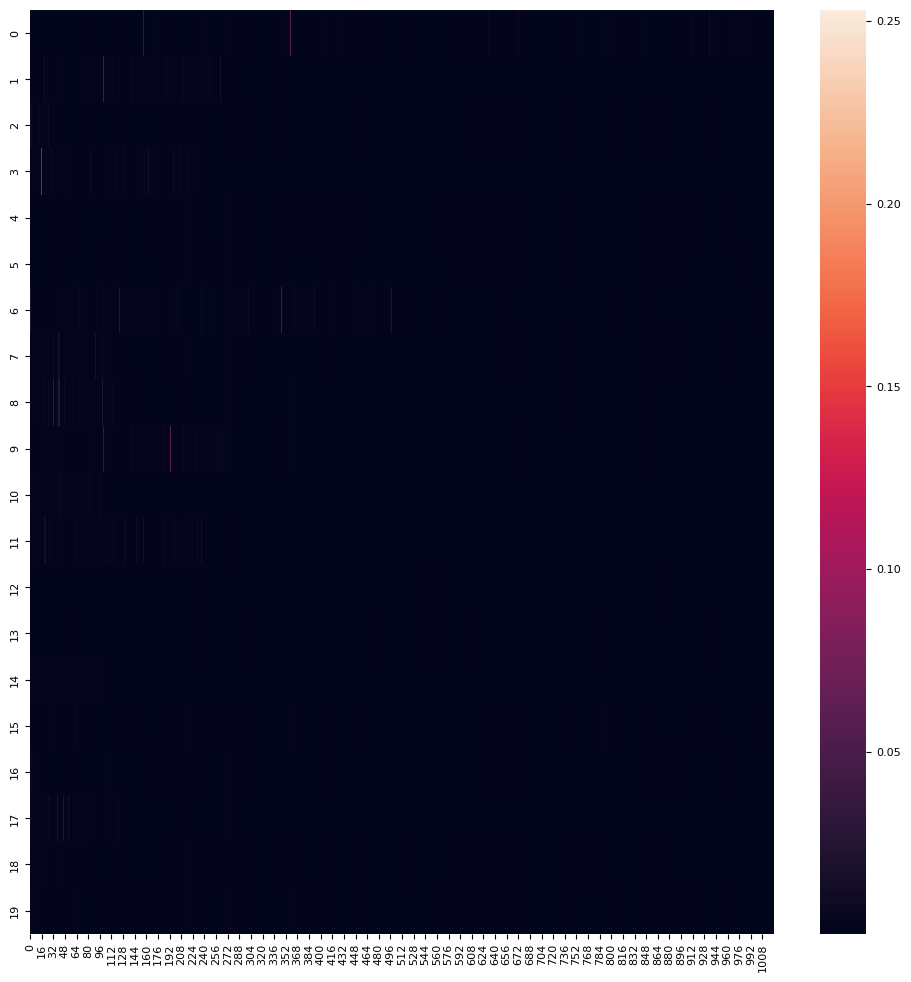

In [59]:
print(len(test_dataset_loader))
analyze_attention_of_df(test_dataset_loader, test_sequence_settings["max_sequence_length"])

##### Coronavirus: Red junglefowl

Grouping labels using config : {'Human': ['Homo sapiens'], 'Desert warthog': ['Phacochoerus aethiopicus'], 'Lesser bandicoot rat': ['Bandicota bengalensis'], 'Horse': ['Equus caballus'], 'Goat': ['Capra hircus'], 'Red junglefowl': ['Gallus gallus'], 'Wood mouse': ['Apodemus sylvaticus'], 'Cattle': ['Bos taurus'], 'Others': ['*']}
label_idx_map={'Cattle': 0, 'Desert warthog': 1, 'Goat': 2, 'Horse': 3, 'Human': 4, 'Lesser bandicoot rat': 5, 'Others': 6, 'Red junglefowl': 7, 'Wood mouse': 8}
idx_label_map={0: 'Cattle', 1: 'Desert warthog', 2: 'Goat', 3: 'Horse', 4: 'Human', 5: 'Lesser bandicoot rat', 6: 'Others', 7: 'Red junglefowl', 8: 'Wood mouse'}
[7]
torch.Size([1, 1024])
seq_len = 64
Label = Red junglefowl
Prediction = Red junglefowl


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/../../src/utils/utils.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/../../src/utils/utils.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/../../src/utils/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

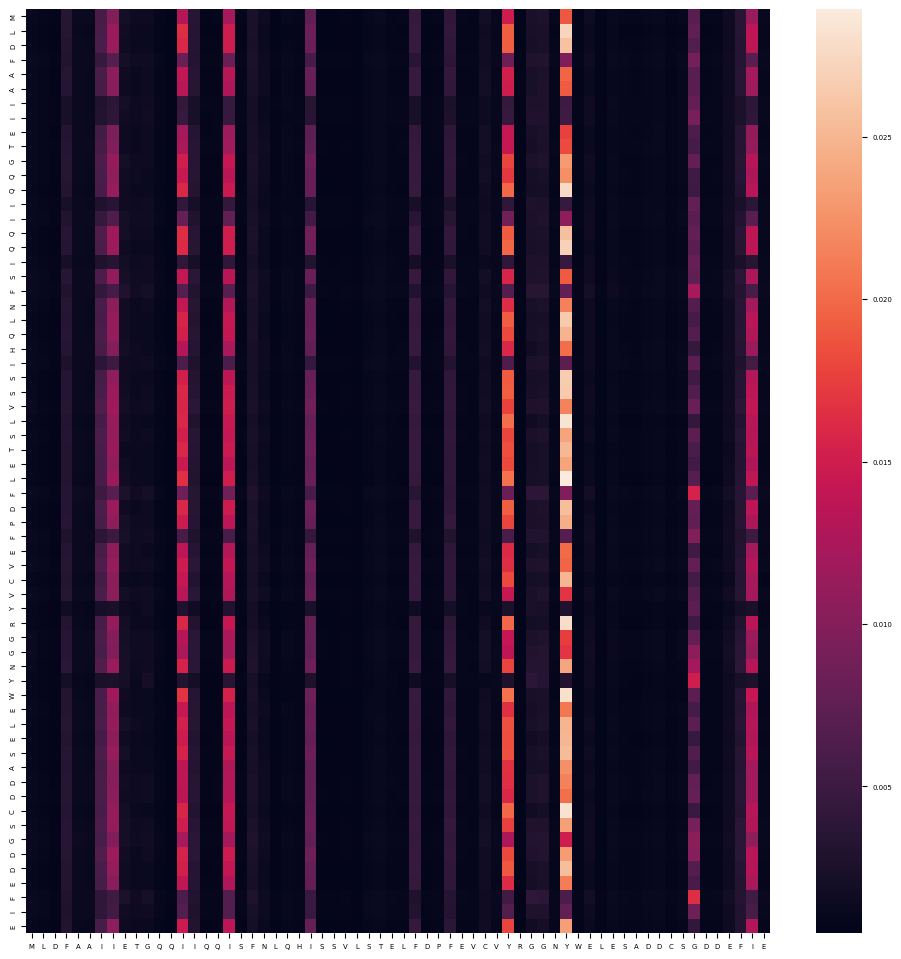

Top 10 tokens + positions with highest attention values for the whole sequence
   tokens  attn_vals  pos
46      Y   0.022722   46
41      Y   0.017443   41
13      I   0.015980   13
17      I   0.015009   17
62      I   0.013656   62
7       I   0.011831    7
24      I   0.008694   24
57      G   0.007217   57
6       I   0.006403    6
33      F   0.004705   33


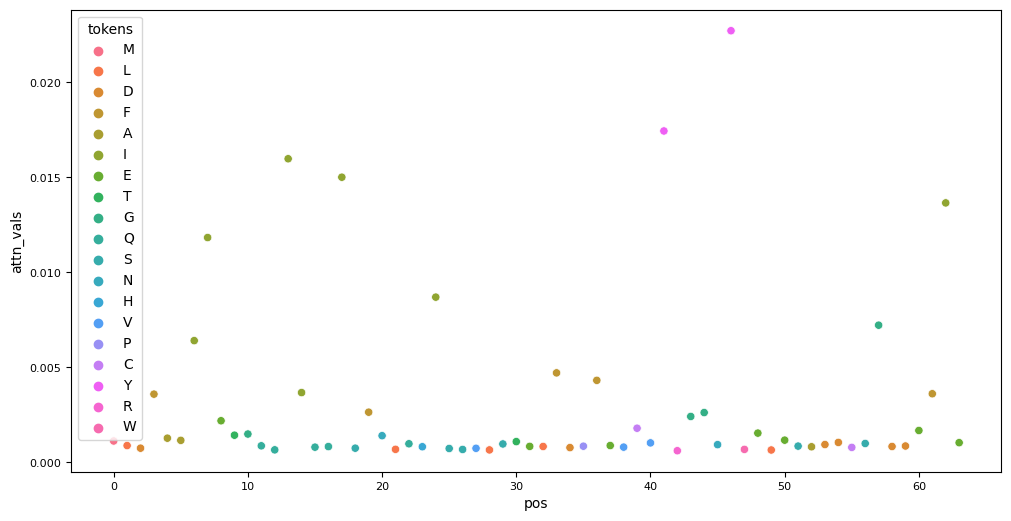

In [64]:
_, test_dataset_loader = load_dataset_with_df(uniref90_coronaviruses_df[uniref90_coronaviruses_df["virus_host_name"] == "Gallus gallus"], test_sequence_settings)
for _, record in enumerate(test_dataset_loader):
    seq, label = record
    analyze_attention_of_prediction(seq, label, test_sequence_settings["max_sequence_length"])
    break

14
109
64
82
82
1024
57
57
65
107
1024
1024
225
109
64
max_seq_len_actual =  1024


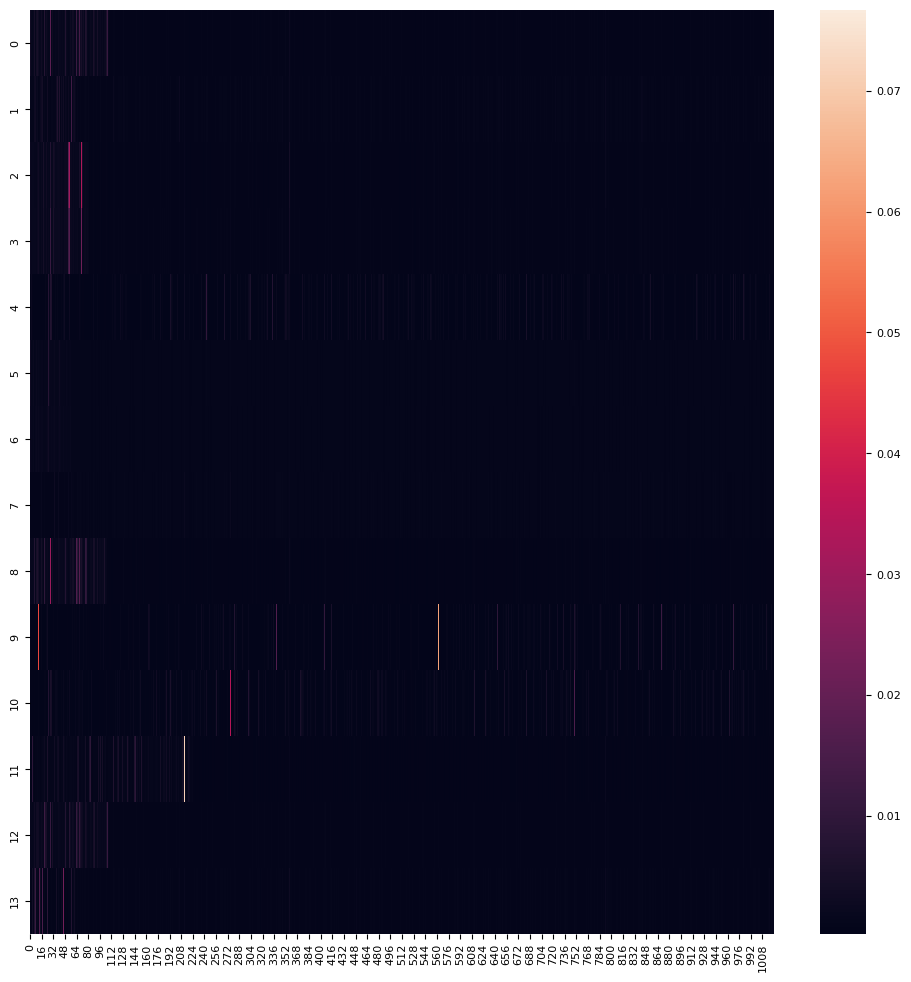

In [65]:
print(len(test_dataset_loader))
analyze_attention_of_df(test_dataset_loader, test_sequence_settings["max_sequence_length"])

##### Coronavirus: Cattle

Grouping labels using config : {'Human': ['Homo sapiens'], 'Desert warthog': ['Phacochoerus aethiopicus'], 'Lesser bandicoot rat': ['Bandicota bengalensis'], 'Horse': ['Equus caballus'], 'Goat': ['Capra hircus'], 'Red junglefowl': ['Gallus gallus'], 'Wood mouse': ['Apodemus sylvaticus'], 'Cattle': ['Bos taurus'], 'Others': ['*']}
label_idx_map={'Cattle': 0, 'Desert warthog': 1, 'Goat': 2, 'Horse': 3, 'Human': 4, 'Lesser bandicoot rat': 5, 'Others': 6, 'Red junglefowl': 7, 'Wood mouse': 8}
idx_label_map={0: 'Cattle', 1: 'Desert warthog', 2: 'Goat', 3: 'Horse', 4: 'Human', 5: 'Lesser bandicoot rat', 6: 'Others', 7: 'Red junglefowl', 8: 'Wood mouse'}
[0]
torch.Size([1, 1024])
seq_len = 43
Label = Cattle
Prediction = Desert warthog


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/../../src/utils/utils.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/../../src/utils/utils.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[~df[label_col].isin(values), label_col] = group_others_key
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/../../src/utils/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

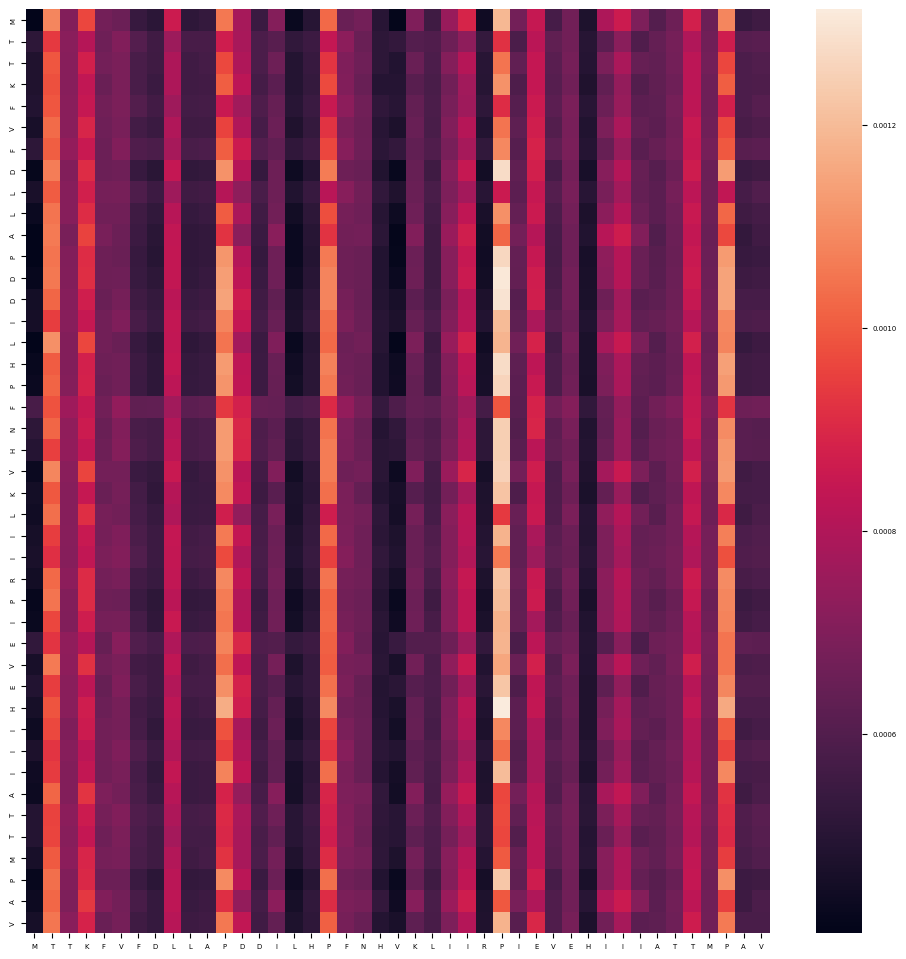

Top 10 tokens + positions with highest attention values for the whole sequence
   tokens  attn_vals  pos
1       T   0.000959    1
27      P   0.000958   27
11      P   0.000911   11
12      D   0.000889   12
40      P   0.000881   40
29      E   0.000876   29
17      P   0.000865   17
38      T   0.000825   38
3       K   0.000808    3
18      F   0.000763   18


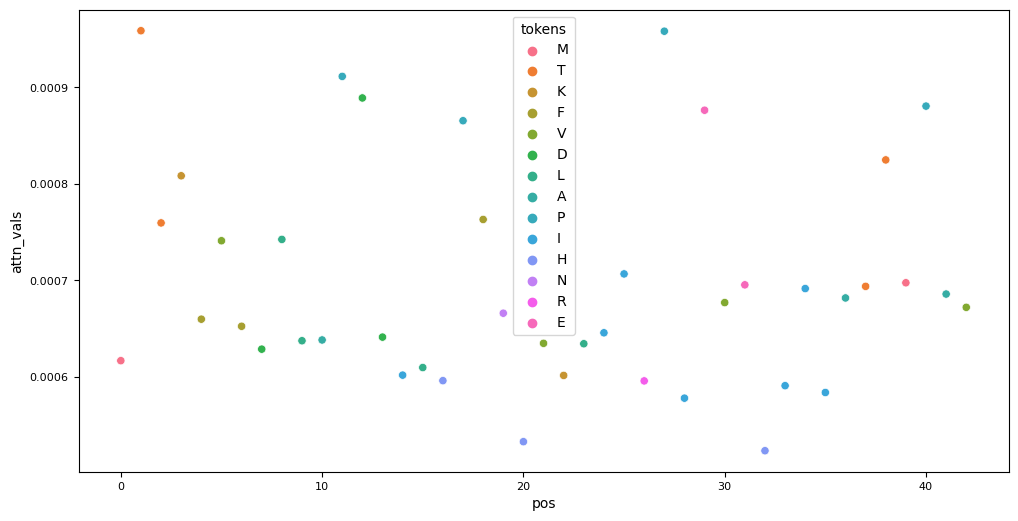

In [67]:
_, test_dataset_loader = load_dataset_with_df(uniref90_coronaviruses_df[uniref90_coronaviruses_df["virus_host_name"] == "Bos taurus"], test_sequence_settings)
for _, record in enumerate(test_dataset_loader):
    seq, label = record
    analyze_attention_of_prediction(seq, label, test_sequence_settings["max_sequence_length"])
    break

1
43
max_seq_len_actual =  43


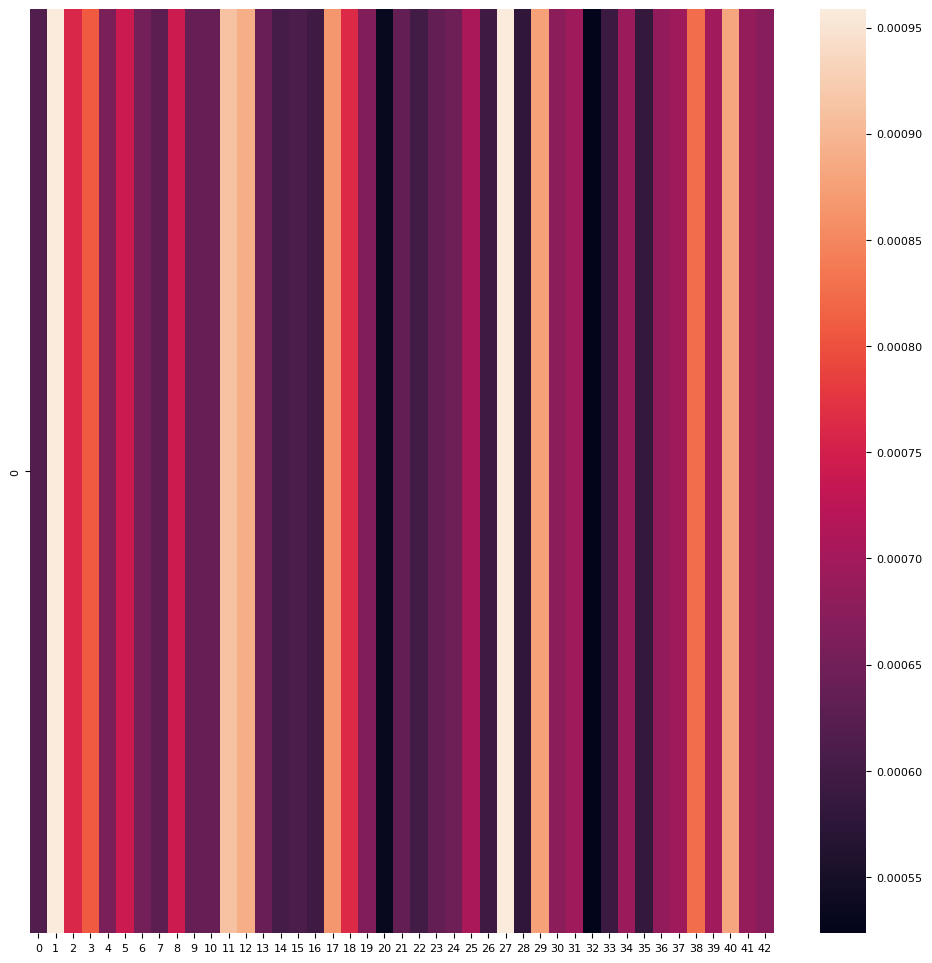

In [68]:
print(len(test_dataset_loader))
analyze_attention_of_df(test_dataset_loader, test_sequence_settings["max_sequence_length"])